### Marketing Final Project
Here we will explore models that can be used to predict who are most vulnerable to churn, and therefore develop forcused intervention plans to retain them.


## Data overview
Each row represents a unique costumer

In [226]:
import pandas as pd

In [227]:
df=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn_original.csv")

In [228]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [229]:
df.groupby('Churn').size()

Churn
No     5174
Yes    1869
dtype: int64

In [230]:
df.groupby('Churn').size() / len(df)

Churn
No     0.73463
Yes    0.26537
dtype: float64

In [231]:
print('row: ', df.shape[0], 'column: ', df.shape[1])
print('Missing value: ' , df.isna().sum().values.sum())

row:  7043 column:  21
Missing value:  0


## Data Cleaning

In [232]:
df.TotalCharges.replace({" ": "0"},inplace=True) #Replacing 11 missing value spaces with zero

In [233]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [234]:
df.TotalCharges=df.TotalCharges.astype('float64') #Change to float type

In [235]:
df = df.drop(columns = ['customerID'])

In [236]:
df0 = df

In [237]:
categorical_cols = [c for c in df.columns if df[c].dtype == 'object'
                    or c == 'SeniorCitizen']
df_categorical = df[categorical_cols].copy()
for col in categorical_cols:
    if df[col].nunique() == 2:
        df[col], _ = pd.factorize(df[col])
    else:
        df = pd.get_dummies(df, columns=[col])

df=df

In [238]:
redundant_columns=df.columns[df.columns.str.contains('No internet service')].tolist()

In [239]:
df.drop(columns=redundant_columns,inplace=True)

In [240]:
df = df.drop(columns = ['MultipleLines_No phone service','MultipleLines_No','OnlineSecurity_No','OnlineBackup_No'\
                       ,'DeviceProtection_No','TechSupport_No','StreamingTV_No','StreamingMovies_No'])

In [241]:
df.columns.size

27

## Data Understanding
### 1 Correlation with churn
<li>Contract monthly, absence of online security and tech support seem to be positively correlated with churn. 
<li>Tenure, two year contracts and services such as Online security, Tech support, Online backup, Device protection seem to be negatively related to churn.
<li>'gender','StreamingMovies_No','StreamingTV_No','StreamingTV_Yes','StreamingMovies_Yes' seem to no difference

In [17]:
df.corr()['Churn'].sort_values(ascending = False)#Get Correlation of "Churn"

Churn                                      1.000000
Contract_Month-to-month                    0.405103
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
MonthlyCharges                             0.193356
SeniorCitizen                              0.150889
Partner                                    0.150448
StreamingTV_Yes                            0.063228
StreamingMovies_Yes                        0.061382
MultipleLines_Yes                          0.040102
PhoneService                               0.011942
gender                                    -0.008612
DeviceProtection_Yes                      -0.066160
OnlineBackup_Yes                          -0.082255
PaymentMethod_Mailed check                -0.091683
PaymentMethod_Bank transfer (automatic)   -0.117937
InternetService_DSL                       -0.124214
PaymentMethod_Credit card (automatic)     -0.134302
Dependents                                -0.164221
TechSupport_

In [18]:
import csv

In [19]:
df.to_csv("/Users/luyi/Downloads/WA_Fn-UseC_-Telco-Customer-Churn_lasso.csv",)

### 2 Correlation matrix check: 'TotalCharges', 'tenure' ; 'MultipleLines_Yes', 'MultipleLines_No' are highly correlated

In [23]:
correlated_features = set()  
correlation_matrix = df.corr()  

In [47]:
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            correlated_features.add(colname)
            correlated_features.add(colname2)

In [48]:
print(correlated_features)  

{'MonthlyCharges', 'InternetService_No', 'tenure', 'TotalCharges', 'InternetService_Fiber optic'}


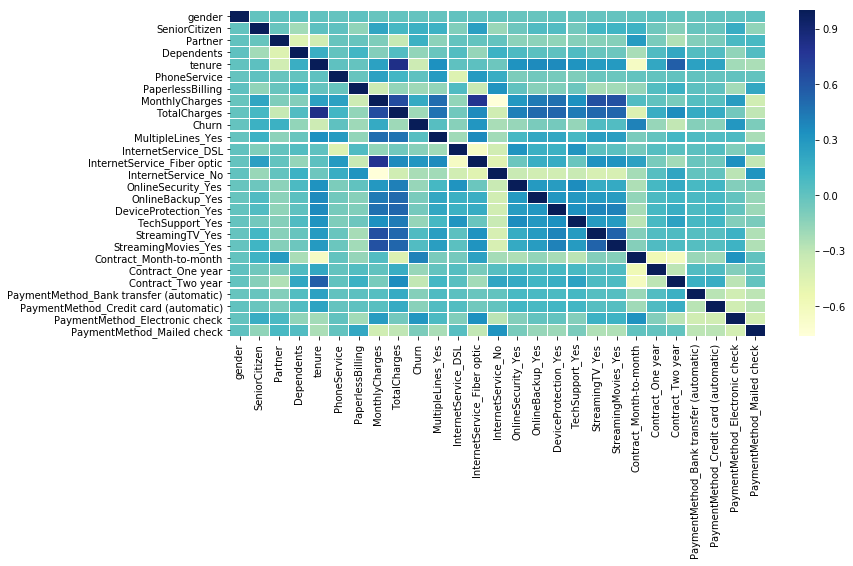

In [57]:
plt.figure(figsize=(12, 6)) 
#corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, 
                 linewidths=.2, cmap="YlGnBu")
#Get Correlation 

### 3 Decision tree


In [242]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [243]:
X = df.drop(columns=['Churn'])

In [244]:
Y = df.Churn

In [245]:
dt = tree.DecisionTreeClassifier(max_depth = 3)

In [246]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

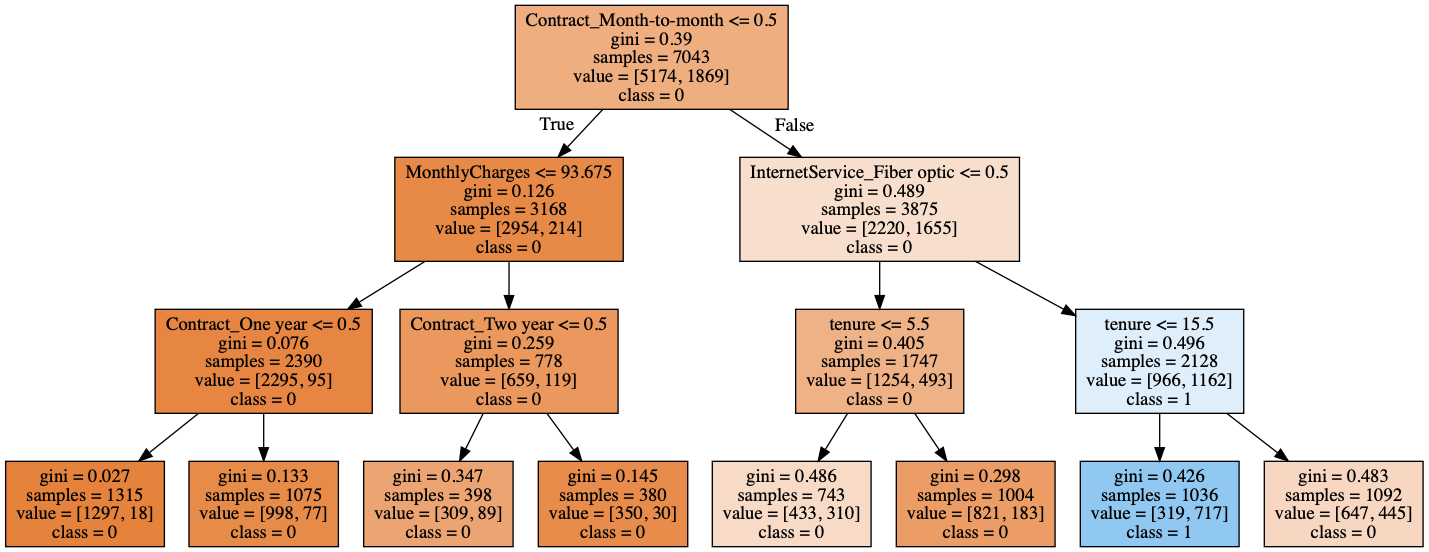

In [247]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

### 4 Plot

In [39]:
import seaborn as sns
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


#### Target variable- Churn
Churn: No - 73%
Churn: Yes - 27.6%

In [40]:
df.groupby('Churn').size() / len(df)

Churn
0    0.73463
1    0.26537
dtype: float64

In [41]:
df.groupby('Churn').size() 

Churn
0    5174
1    1869
dtype: int64

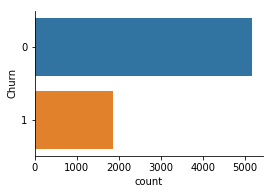

In [42]:
sns.catplot(data=df,y='Churn',
        kind = 'count',height=2.6, aspect=1.5)


#### Numerical features- Tenure, monthly charges and total charges
<li>New clients are more likely to churn 
<li>Clients with higher MonthlyCharges are also more likely to churn
<li>Tenure and MonthlyCharges are probably important features

In [43]:
def kdeplot(f):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(f))
    ax0 = sns.kdeplot(df[df['Churn'] == 0][f], color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == 1][f], color= 'orange', label= 'Churn: Yes')

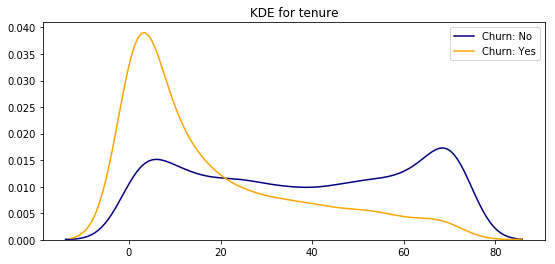

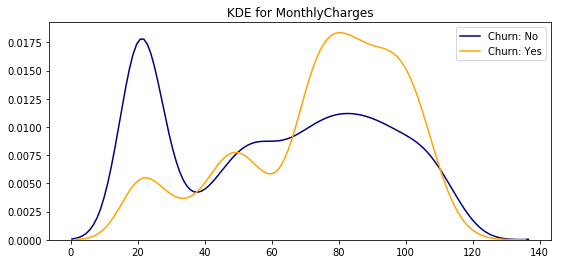

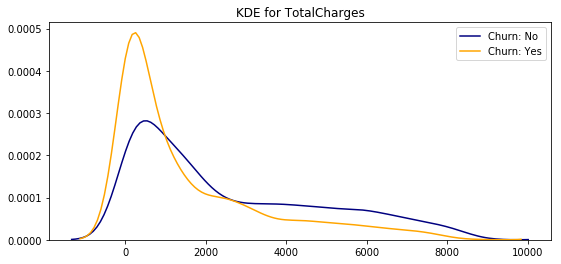

In [44]:
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

#### Categorial features - Internet service
<li>Clients without internet have a very low churn rate
<li>Customers with fiber are more probable to churn than those with DSL connection


In [207]:
df00.groupby('InternetService')['MonthlyCharges'].max()

InternetService
DSL             94.80
Fiber optic    118.75
Name: MonthlyCharges, dtype: float64

In [195]:
df00 = df0[df0.InternetService != 'No']

In [196]:
df00 = df00.replace({'Yes':1,'No':0})

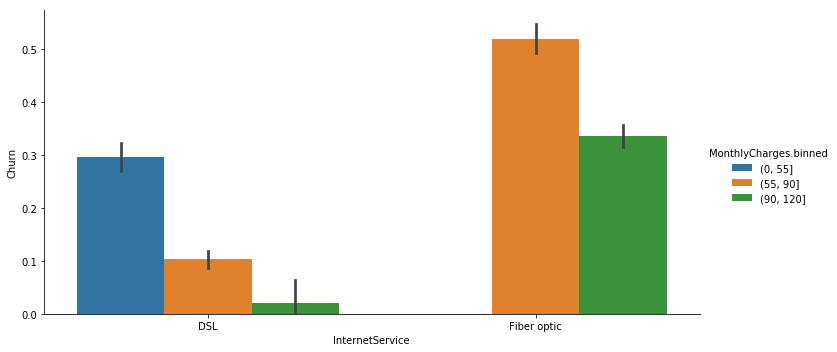

In [208]:
df00['MonthlyCharges.binned'] = pd.cut(df00['MonthlyCharges'],bins=[0,55,90,120])
sns.catplot(data=df00,hue='MonthlyCharges.binned',x='InternetService', y='Churn',
           kind='bar', aspect=2)

In [214]:
df001 = df0['Churn'].replace({'Yes':1,'No':0})

In [215]:
df001['MonthlyCharges.binned'] = pd.cut(df001['MonthlyCharges'],bins=[0,55,90,120])
sns.catplot(data=df001,hue='MonthlyCharges.binned',x='InternetService', y='Churn',
           kind='bar', aspect=2)

KeyError: 'MonthlyCharges'

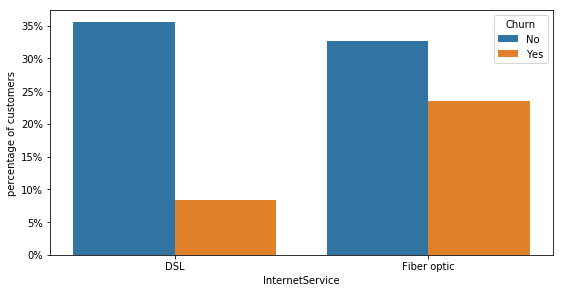

In [146]:

def barplot_percentages(f, orient='v', axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    g = df00.groupby(f)["Churn"].value_counts().to_frame()
    g = g.rename({"Churn": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(df)
    if orient == 'v':
        ax = sns.barplot(x=f, y= axis_name, hue='Churn', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=f, hue='Churn', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()

plt.figure(figsize=(9, 4.5))
barplot_percentages('InternetService')

<li>It's interesting how customers with DSL (slower connection) and higher charges are less probable to churn.

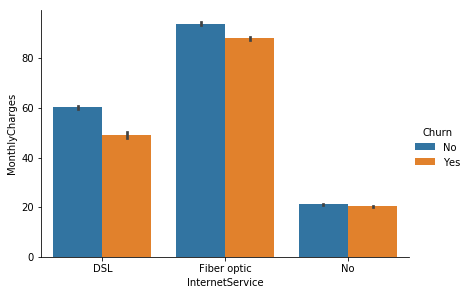

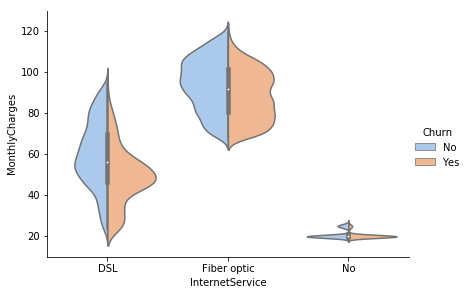

In [49]:
ax = sns.catplot(data = df0, x="InternetService", y="MonthlyCharges", hue="Churn", kind="bar",
                  height=4.2, aspect=1.4);
ax = sns.catplot(x="InternetService", y="MonthlyCharges", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=df0, height=4.2, aspect=1.4);

#### Categorial features - Six additional services
<li>Customers with the first 4 additionals (security to tech support) are less likely to churn
<li>Streaming service is not predictive for churn

In [178]:
cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

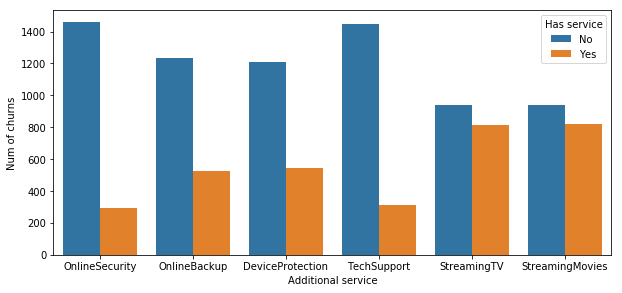

In [179]:
plt.figure(figsize=(10, 4.5))
df1 = df0[(df0.InternetService != 'No') & (df0.Churn == 'Yes')]
df1 = pd.melt(df1[cols]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data=df1, x='variable', hue='Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Additional service', ylabel='Num of churns')
plt.show()

## Clustering


In [180]:
import seaborn as sns
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [181]:
import warnings
warnings.filterwarnings('ignore')

Finding the best clustering method, KMeans(2 cluster)

In [182]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

bestSil = -1
for k in range(2,10):
    clus = [KMeans(n_clusters=k,n_jobs=-1), Birch(n_clusters=k), 
            AgglomerativeClustering(n_clusters=k)]
    for cl in clus:
        res = cl.fit(df)
        sil = metrics.silhouette_score(df, res.labels_)
        print (str(cl)[:10] + ' with k =' +str(k) + ": " + str(round(sil,4)))
        if (sil > bestSil):
            bestSil = sil
            bestCl = cl

KMeans(alg with k =2: 0.7031
Birch(bran with k =2: 0.7028
Agglomerat with k =2: 0.7028
KMeans(alg with k =3: 0.6448
Birch(bran with k =3: 0.5824
Agglomerat with k =3: 0.5824
KMeans(alg with k =4: 0.6022
Birch(bran with k =4: 0.5709
Agglomerat with k =4: 0.5709
KMeans(alg with k =5: 0.5967
Birch(bran with k =5: 0.5823
Agglomerat with k =5: 0.5823
KMeans(alg with k =6: 0.5938
Birch(bran with k =6: 0.5836
Agglomerat with k =6: 0.5836
KMeans(alg with k =7: 0.5838
Birch(bran with k =7: 0.5721
Agglomerat with k =7: 0.5207
KMeans(alg with k =8: 0.5707
Birch(bran with k =8: 0.5802
Agglomerat with k =8: 0.5091
KMeans(alg with k =9: 0.5706
Birch(bran with k =9: 0.5173
Agglomerat with k =9: 0.5173


In [183]:
bestCl

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [185]:
df1 = df.drop(columns=['tenure','MultipleLines_No'])

In [186]:
df_norm = df1.copy()
df_norm = (df_norm - df_norm.mean()) / df_norm.std()

In [187]:
clu = KMeans(n_clusters=2,random_state=0)
clu.fit(df_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [188]:
df2 = df1.copy()
df2['cluster'] = clu.labels_
df2.groupby('cluster').mean().T

cluster,0,1
gender,0.510485,0.503172
SeniorCitizen,0.034076,0.197571
Partner,0.516383,0.517129
Dependents,0.421363,0.265905
PhoneService,1.000000,0.876382
PaperlessBilling,0.707733,0.324814
MonthlyCharges,21.079194,76.844254
TotalCharges,662.604784,2727.031684
Churn,0.074050,0.318289
MultipleLines_Yes,0.224115,0.476527


## Classification for Prediction

## random forest
### 1 - Most Simple

In [193]:
import sklearn as sk

In [194]:
X = df.drop(columns=['Churn'])

In [195]:
Y = df.Churn

In [196]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,
                            test_size=0.3,random_state = 0)

In [198]:
from sklearn.ensemble import RandomForestClassifier

cl = RandomForestClassifier(random_state=2)
cl.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [199]:
y_pred = cl.predict(X_test)

### collect scores

#### Confusion matrix

In [200]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,y_pred)

array([[1412,  148],
       [ 318,  235]])

#### Accuracy

In [206]:
#### 1 - (y_pred - Y_test).abs().mean()

#### Precision

In [207]:
import sklearn
sklearn.metrics.precision_score(Y_test,y_pred)

0.6135770234986945

#### Recall

In [208]:
sklearn.metrics.recall_score(Y_test,y_pred)

0.42495479204339964

#### AUC score

In [209]:
y_proba = cl.predict_proba(X_test)[:,1]

In [210]:
sklearn.metrics.roc_auc_score(Y_test,y_proba)

0.7940308109611907

#### Predict the churn rate for each customer based on the RandomFrorest Model

In [211]:
y_proba = cl.predict_proba(X_test)

### Cross-validation

In [212]:
cl

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [213]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,random_state=0,shuffle=True)
sklearn.model_selection.cross_val_score(cl,X,Y,cv=kf,scoring='roc_auc').mean()

0.794060653528003

## random forest
### 2 - more trees

In [232]:
import sklearn as sk

In [233]:
X = df.drop(columns=['Churn'])

In [234]:
Y = df.Churn

In [235]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,
                            test_size=0.3,random_state = 0)

In [236]:
from sklearn.ensemble import RandomForestClassifier

cl = RandomForestClassifier(n_estimators = 100, random_state=2)
cl.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [237]:
y_pred = cl.predict(X_test)

### collect scores

#### Confusion matrix

In [238]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,y_pred)

array([[1382,  178],
       [ 283,  270]])

#### Accuracy

In [239]:
#### 1 - (y_pred - Y_test).abs().mean()

#### Precision

In [240]:
import sklearn
sklearn.metrics.precision_score(Y_test,y_pred)

0.6026785714285714

#### Recall

In [241]:
sklearn.metrics.recall_score(Y_test,y_pred)

0.488245931283906

#### AUC score

In [242]:
y_proba = cl.predict_proba(X_test)[:,1]

In [243]:
sklearn.metrics.roc_auc_score(Y_test,y_proba)

0.8155631288542682

#### Predict the churn rate for each customer based on the RandomFrorest Model

In [244]:
y_proba = cl.predict_proba(X_test)

### Cross-validation

In [245]:
cl

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [246]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,random_state=0,shuffle=True)
sklearn.model_selection.cross_val_score(cl,X,Y,cv=kf,scoring='roc_auc').mean()

0.8228708208485112

## random forest
### 3 - change default value 


In [741]:
import sklearn as sk

In [742]:
X = df.drop(columns=['Churn'])

In [743]:
Y = df.Churn

In [744]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,
                            test_size=0.3,random_state = 0)

In [745]:
from sklearn.ensemble import RandomForestClassifier
cl0 = RandomForestClassifier(n_estimators = 1000, random_state=2, min_samples_leaf = 35, max_features= 3)
cl0.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=35, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [746]:
y_pred = cl0.predict(X_test)

### collect scores

#### Confusion matrix

In [747]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,y_pred)

array([[1448,  112],
       [ 311,  242]])

#### Accuracy

In [748]:
#### 1 - (y_pred - Y_test).abs().mean()

#### Precision

In [749]:
import sklearn
sklearn.metrics.precision_score(Y_test,y_pred)

0.6836158192090396

#### Recall

In [750]:
sklearn.metrics.recall_score(Y_test,y_pred)

0.4376130198915009

#### AUC score

In [751]:
y_proba = cl0.predict_proba(X_test)[:,1]

In [752]:
sklearn.metrics.roc_auc_score(Y_test,y_proba)

0.8390225807947327

#### Predict the churn rate for each customer based on the RandomFrorest Model

In [753]:
y_proba = cl0.predict_proba(X_test)

### Cross-validation

In [754]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,random_state=0,shuffle=True)
sklearn.model_selection.cross_val_score(cl0,X,Y,cv=kf,scoring='roc_auc').mean()

0.8477905804293033

In [755]:
cl.feature_importances_.size

31

In [756]:
X.columns.size

26

In [757]:
coef_dict={}

for name, importance in zip(X.columns.values, cl.feature_importances_):
    print(name, "=", importance)

gender = 0.003178601573419183
SeniorCitizen = 0.001969306910440337
Partner = 0.0015735570741772706
Dependents = 0.001829897063512215
tenure = 0.196282494022918
PhoneService = 0.0015288585424367762
PaperlessBilling = 0.004725910912752024
MonthlyCharges = 0.06852458356214088
TotalCharges = 0.0811712066306908
MultipleLines_Yes = 0.008384149741722892
InternetService_DSL = 0.019241087694746018
InternetService_Fiber optic = 0.07647240034323703
InternetService_No = 0.006574356285576324
OnlineSecurity_Yes = 0.07861513944518032
OnlineBackup_Yes = 0.007753845186648456
DeviceProtection_Yes = 0.0155793988748361
TechSupport_Yes = 0.0024320455047919486
StreamingTV_Yes = 0.0036442811355074946
StreamingMovies_Yes = 0.0010285005697858029
Contract_Month-to-month = 0.08474834542875861
Contract_One year = 0.004942570720799376
Contract_Two year = 0.0023425872656944492
PaymentMethod_Bank transfer (automatic) = 0.003613330270944421
PaymentMethod_Credit card (automatic) = 0.003137424549964016
PaymentMethod_El

In [758]:
features = X.columns.values
importances = cl.feature_importances_
indices = np.argsort(importances)

plt.size()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='c', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'size'

In [ ]:
feat_importances = pd.Series(cl.feature_importances_, index=X.columns.values)
feat_importances.nlargest(4).plot(kind='barh')

In [ ]:
weights = pd.Series(cl.feature_importances_,
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[-10:].plot(kind='bar'))

## random forest
### 4 - put limited variables based on LASSO

In [759]:
import sklearn as sk

In [760]:
X = df.drop(columns=['Churn','PaymentMethod_Mailed check','MultipleLines_Yes'])

In [761]:
Y = df.Churn

In [762]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,
                            test_size=0.3,random_state = 0)

In [763]:
from sklearn.ensemble import RandomForestClassifier

cl = RandomForestClassifier(n_estimators = 100, random_state=2, min_samples_leaf = 50, max_features= 10)
cl.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [764]:
y_pred = cl.predict(X_test)

### collect scores

#### Confusion matrix

In [765]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,y_pred)

array([[1405,  155],
       [ 266,  287]])

#### Accuracy

In [766]:
#### 1 - (y_pred - Y_test).abs().mean()

#### Precision

In [767]:
import sklearn
sklearn.metrics.precision_score(Y_test,y_pred)

0.6493212669683258

#### Recall

In [768]:
sklearn.metrics.recall_score(Y_test,y_pred)

0.5189873417721519

#### AUC score

In [769]:
y_proba = cl.predict_proba(X_test)[:,1]

In [770]:
sklearn.metrics.roc_auc_score(Y_test,y_proba)

0.8395871006630501

#### Predict the churn rate for each customer based on the RandomFrorest Model

In [771]:
y_proba = cl.predict_proba(X_test)

### Cross-validation

In [772]:
cl

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [773]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,random_state=0,shuffle=True)
sklearn.model_selection.cross_val_score(cl,X,Y,cv=kf,scoring='roc_auc').mean()

0.8460942432268282

#### Which classifier obtains the highest performance?

In [215]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.neural_network import MLPClassifier
#from sklearn.ensemble import BaggingClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier

#clfs = [DecisionTreeClassifier(), sk.ensemble.RandomForestClassifier(n_jobs=-1), sk.naive_bayes.GaussianNB(),
        #sk.linear_model.LogisticRegression(n_jobs=-1),sk.tree.DecisionTreeClassifier(),sk.ensemble.AdaBoostClassifier(),
        #QuadraticDiscriminantAnalysis(),MLPClassifier(),SVC()]

In [216]:
# for every classifier in clfs, perform cross-validation, and return the 
# classifier with the largest average AUC
#maxAUC = -1
#bestCL = ''
#for cl in clfs:
#    kf = KFold(n_splits=10,random_state=2,shuffle=True)
#    auc = sklearn.model_selection.cross_val_score(cl,X,Y,cv=kf,scoring='roc_auc').mean()
#    if auc > maxAUC:
#        bestCl = cl
#        maxAUC = auc
#print (str(bestCl) + ': ' +str(maxAUC))

<li> With ADA Boost I was able to increase the accuracy on test data to almost 85%. Clearly, ADA Boost is a winner among all other techniques.

# Logistic Regression

## 1 - pure logistic

In [582]:
X = df.drop(columns=['Churn'])

In [583]:
Y = df.Churn

In [584]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [585]:
from sklearn.linear_model import LogisticRegression
plr = LogisticRegression(C=10**10, penalty = 'l2')
plr.fit(X_train, y_train)

LogisticRegression(C=10000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [586]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,random_state=0,shuffle=True)
sklearn.model_selection.cross_val_score(plr,X,Y,cv=kf,scoring='roc_auc').mean()

0.8444134229229354

In [587]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1546
           1       0.25      0.18      0.21       567

   micro avg       0.64      0.64      0.64      2113
   macro avg       0.49      0.49      0.49      2113
weighted avg       0.60      0.64      0.62      2113



No handles with labels found to put in legend.


Text(0.5, 0, 'False Positive Rate')

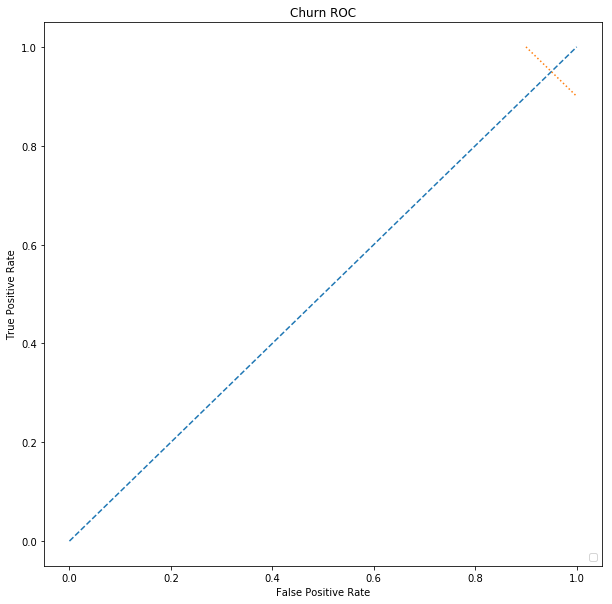

In [739]:
y_prob = ridgelr.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Churn ROC')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.plot([0.9, 1], [1, 0.9],linestyle=':')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [589]:
coef_dict={}
for feat, coef in zip(X_train.columns, plr.coef_[0,:]): coef_dict[feat] = coef

In [590]:
from pandas import Series
Series(coef_dict)

gender                                     0.020262
SeniorCitizen                              0.191103
Partner                                    0.008270
Dependents                                -0.131970
tenure                                    -0.058644
PhoneService                              -0.521567
PaperlessBilling                          -0.347457
MonthlyCharges                             0.004245
TotalCharges                               0.000303
MultipleLines_No                          -0.344577
MultipleLines_Yes                         -0.176991
InternetService_DSL                       -0.317560
InternetService_Fiber optic                0.392303
InternetService_No                        -0.351270
OnlineSecurity_No                          0.209242
OnlineSecurity_Yes                        -0.134499
OnlineBackup_No                            0.165764
OnlineBackup_Yes                          -0.091021
DeviceProtection_No                        0.079215
DeviceProtec

## 2 - logistic + LASSO:  PaymentMethod_Mailed and MultipleLines_Yes drop

In [591]:
X = df.drop(columns=['Churn'])

In [592]:
Y = df.Churn

In [593]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [594]:
from sklearn.linear_model import LogisticRegression
lassolr = LogisticRegression(penalty = 'l1')
lassolr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [595]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,random_state=0,shuffle=True)
sklearn.model_selection.cross_val_score(lassolr,X,Y,cv=kf,scoring='roc_auc').mean()

0.84501428096734

In [596]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1546
           1       0.25      0.18      0.21       567

   micro avg       0.64      0.64      0.64      2113
   macro avg       0.49      0.49      0.49      2113
weighted avg       0.60      0.64      0.62      2113



Text(0.5, 0, 'False Positive Rate')

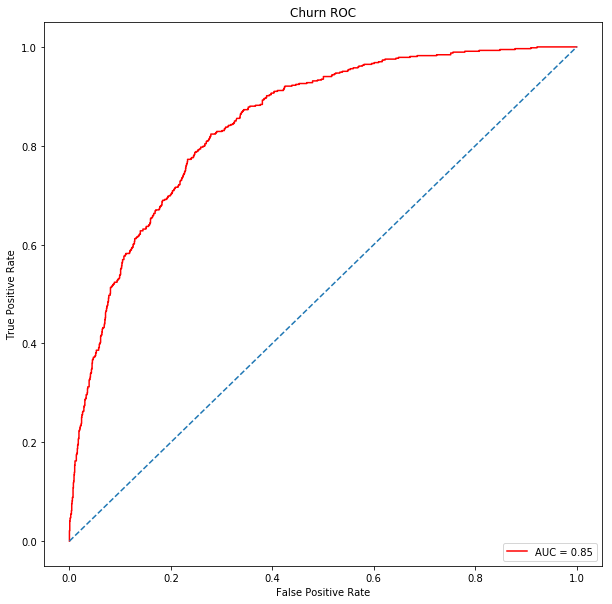

In [597]:
y_prob = ridgelr.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Churn ROC')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [598]:
coef_dict={}
for feat, coef in zip(X_train.columns, lassolr.coef_[0,:]): coef_dict[feat] = coef

In [599]:
from pandas import Series
Series(coef_dict)

gender                                     0.019679
SeniorCitizen                              0.194632
Partner                                    0.000000
Dependents                                -0.135234
tenure                                    -0.058340
PhoneService                              -0.577694
PaperlessBilling                          -0.363708
MonthlyCharges                             0.000555
TotalCharges                               0.000299
MultipleLines_No                          -0.188208
MultipleLines_Yes                          0.000000
InternetService_DSL                       -0.329691
InternetService_Fiber optic                0.464201
InternetService_No                        -0.551759
OnlineSecurity_No                          0.086306
OnlineSecurity_Yes                        -0.216792
OnlineBackup_No                            0.072411
OnlineBackup_Yes                          -0.152151
DeviceProtection_No                        0.018312
DeviceProtec

AxesSubplot(0.125,0.125;0.775x0.755)


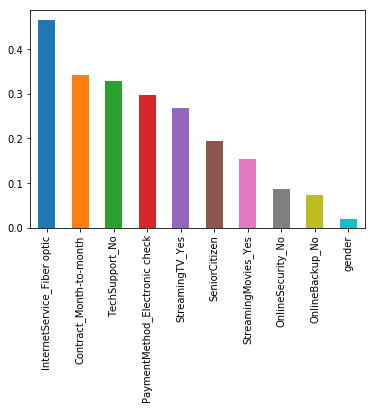

In [600]:
import pandas as pd
import numpy as np

X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_,index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [620]:
weights = pd.Series(cl.feature_importances_,
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[-10:].plot(kind='bar'))

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

## 3 - logistic + Ridge

In [602]:
X = df.drop(columns=['Churn'])

In [603]:
Y = df.Churn

In [604]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [605]:
from sklearn.linear_model import LogisticRegression
ridgelr = LogisticRegression()
ridgelr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [606]:
coef_dict={}
for feat, coef in zip(X_train.columns, ridgelr.coef_[0,:]): coef_dict[feat] = coef

In [607]:
from pandas import Series
Series(coef_dict)

gender                                     0.019652
SeniorCitizen                              0.191076
Partner                                    0.006200
Dependents                                -0.134147
tenure                                    -0.058814
PhoneService                              -0.516612
PaperlessBilling                          -0.348314
MonthlyCharges                             0.004313
TotalCharges                               0.000303
MultipleLines_No                          -0.342914
MultipleLines_Yes                         -0.173697
InternetService_DSL                       -0.314561
InternetService_Fiber optic                0.388611
InternetService_No                        -0.347934
OnlineSecurity_No                          0.209091
OnlineSecurity_Yes                        -0.135041
OnlineBackup_No                            0.165040
OnlineBackup_Yes                          -0.090990
DeviceProtection_No                        0.079306
DeviceProtec

In [608]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,random_state=0,shuffle=True)
sklearn.model_selection.cross_val_score(ridgelr,X,Y,cv=kf,scoring='roc_auc').mean()

0.8443942747352884

In [609]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1546
           1       0.25      0.18      0.21       567

   micro avg       0.64      0.64      0.64      2113
   macro avg       0.49      0.49      0.49      2113
weighted avg       0.60      0.64      0.62      2113



Text(0.5, 0, 'False Positive Rate')

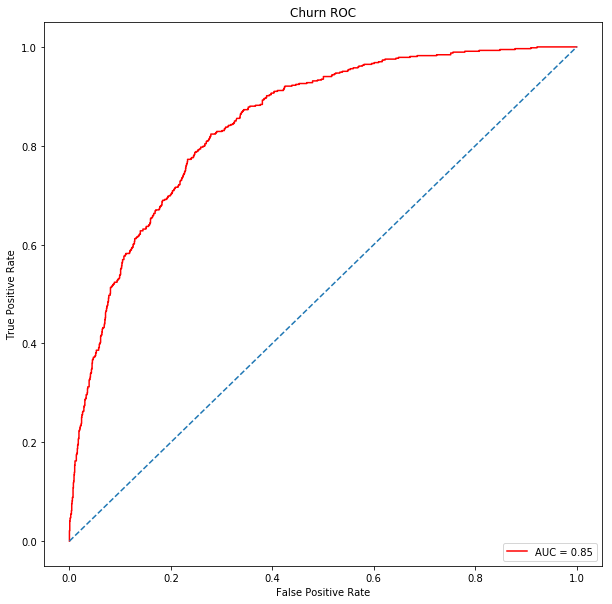

In [610]:
y_prob = ridgelr.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Churn ROC')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 0, 'False Positive Rate')

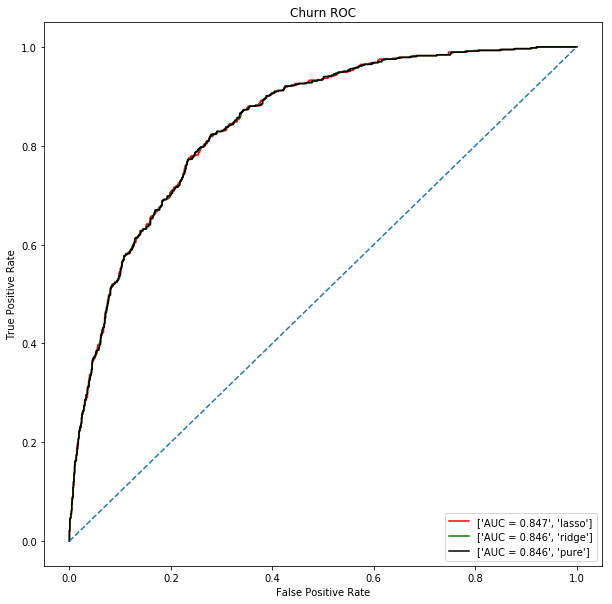

In [611]:
y_prob = ridgelr.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_prob1 = lassolr.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_prob2 = plr.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  


from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
false_positive_rate1, true_positive_rate1, thresholds = roc_curve(y_test, y_prob1)
false_positive_rate2, true_positive_rate2, thresholds = roc_curve(y_test, y_prob2)

roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
roc_auc2 = auc(false_positive_rate2, true_positive_rate2)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Churn ROC')
plt.plot(false_positive_rate1,true_positive_rate1, color='red',label = ['AUC = %0.3f' % roc_auc1,'lasso'])
plt.plot(false_positive_rate,true_positive_rate, color='green',label = ['AUC = %0.3f' % roc_auc,'ridge'])
plt.plot(false_positive_rate2,true_positive_rate2, color='black',label = ['AUC = %0.3f' % roc_auc2,'pure'])

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [613]:
# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(y[half:], probas_[:, 1])
area = auc(recall, precision)

pl.clf()
pl.plot(recall, precision, label='Precision-Recall curve')
pl.xlabel('Recall')
pl.ylabel('Precision')
pl.ylim([0.0, 1.05])
pl.xlim([0.0, 1.0])

pl.legend(loc="lower left")
pl.show()

NameError: name 'y' is not defined

# ABOUT threshold

In [424]:
y_scores = ridgelr.predict_proba(X_test)[:, 1]
# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)

In [425]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [426]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg      1521        25
pos       458       109


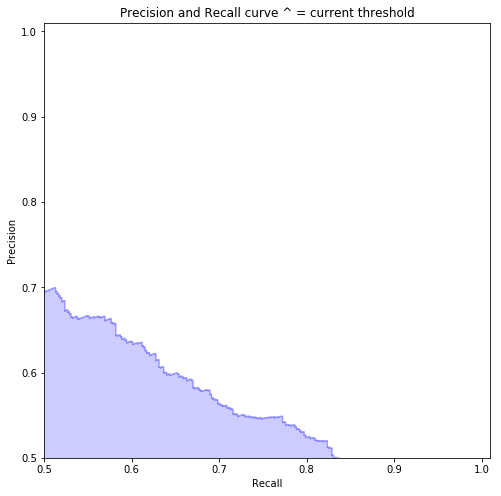

In [617]:
precision_recall_threshold(p, r, thresholds, 0.7)

### OR

In [434]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

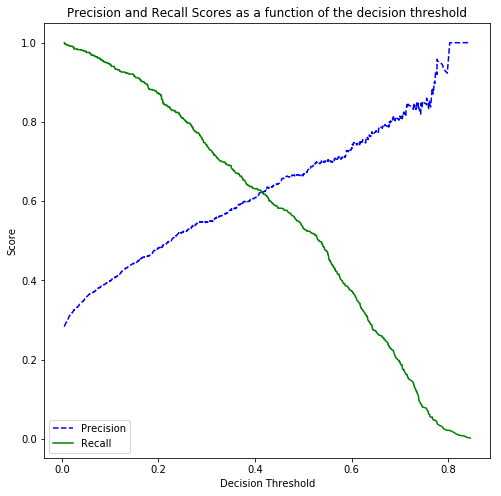

In [435]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)